In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwordsP
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

In [87]:
df = pd.read_csv("amazon_alexa.tsv", sep='\t')

In [88]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [90]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [91]:
df.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [92]:
df[df['verified_reviews'].isnull()]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [93]:
df['verified_reviews'] = df['verified_reviews'].fillna(df['verified_reviews'].mode()[0])

In [94]:
df.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,0
feedback,0


In [95]:
df.duplicated().sum()

np.int64(715)

In [96]:
df.shape

(3150, 5)

In [97]:
df['verified_reviews']

,verified_reviews
0,Love my Echo!
1,Loved it!
2,"Sometimes while playing a game, you can answer..."
3,I have had a lot of fun with this thing. My 4 ...
4,Music
...,...
3145,"Perfect for kids, adults and everyone in betwe..."
3146,"Listening to music, searching locations, check..."
3147,"I do love these things, i have them running my..."
3148,Only complaint I have is that the sound qualit...


In [98]:
df['length'] = df['verified_reviews'].apply(len)

In [99]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


<Axes: ylabel='Frequency'>

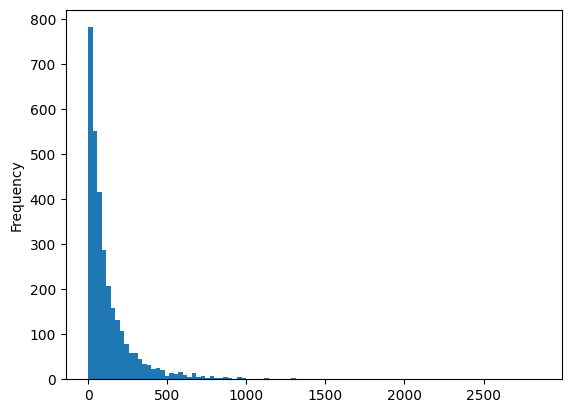

In [100]:
df['length'].plot(bins=100, kind='hist')

The histogram demonstrates that only the length of a few reviews exceeded 500 characters. Let's explore more statistical detail regarding the review lenghts.

In [101]:
df.length.describe()

,length
count,3150.000000
mean,132.048571
std,182.100630
min,1.000000
25%,30.000000
50%,74.000000
75%,165.000000
max,2851.000000


In [102]:
df[df['length'] == 2851]['verified_reviews'].iloc[0]

"Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This order came with a free Phi

In [103]:
df[df['length'] == 1]['verified_reviews'].iloc[0]

'😍'

In [104]:
df.nunique()

,0
rating,5
date,77
variation,16
verified_reviews,2300
feedback,2
length,490


In [105]:
df['feedback'].value_counts()

,count
feedback,
1,2893
0,257


In [106]:
negative = df[df['feedback']==0]
positive = df[df['feedback']==1]

In [107]:
negative

,rating,date,variation,verified_reviews,feedback,length
46,2,30-Jul-18,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc...",0,163
111,2,30-Jul-18,Charcoal Fabric,Sound is terrible if u want good music too get...,0,53
141,1,30-Jul-18,Charcoal Fabric,Not much features.,0,18
162,1,30-Jul-18,Sandstone Fabric,"Stopped working after 2 weeks ,didn't follow c...",0,87
176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0,20
...,...,...,...,...,...,...
3047,1,30-Jul-18,Black Dot,Echo Dot responds to us when we aren't even ta...,0,120
3048,1,30-Jul-18,White Dot,NOT CONNECTED TO MY PHONE PLAYLIST :(,0,37
3067,2,30-Jul-18,Black Dot,The only negative we have on this product is t...,0,240
3091,1,30-Jul-18,Black Dot,I didn’t order it,0,17


In [108]:
positive

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,135
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,441
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,380


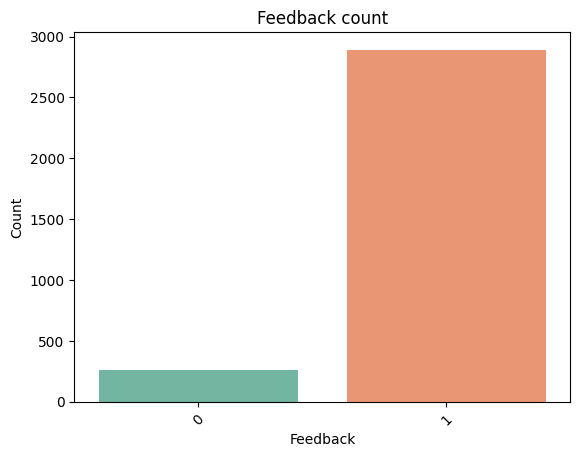

In [109]:
sns.countplot(x='feedback', data=df, palette='Set2')
plt.title('Feedback count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

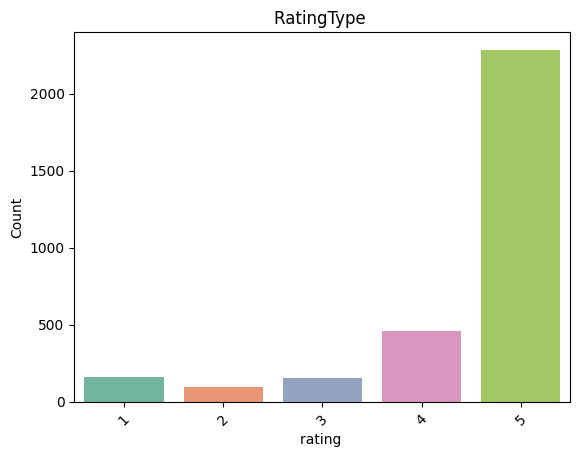

In [110]:
sns.countplot(x='rating', data=df ,palette='Set2')
plt.title('RatingType ')
plt.xlabel('rating ')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='variation', ylabel='rating'>

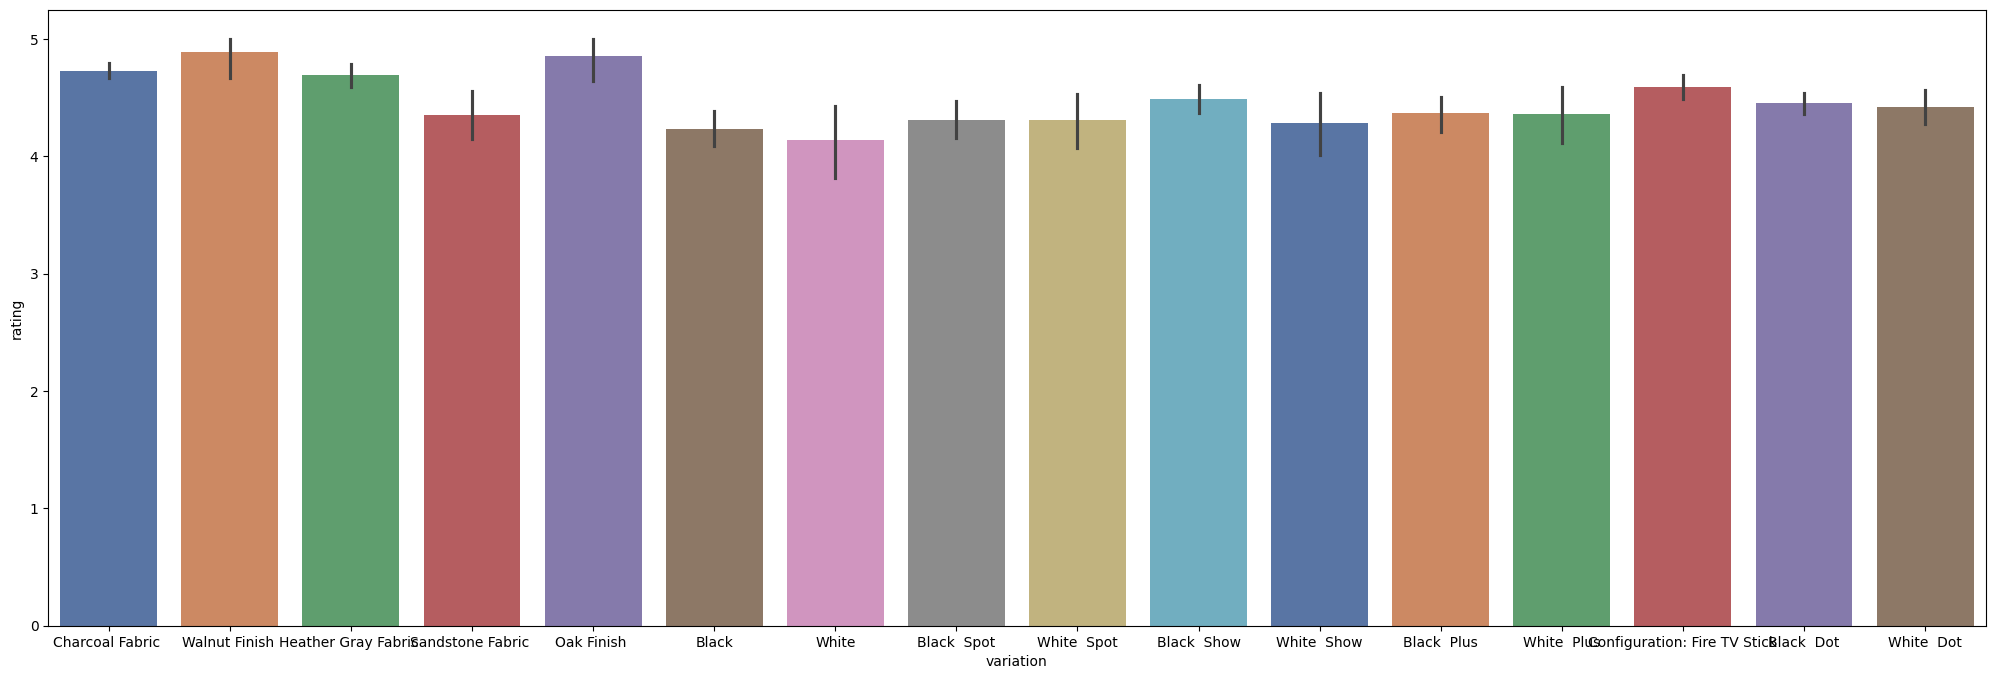

In [111]:
plt.figure(figsize = (25,8))
sns.barplot(x = 'variation', y='rating', data = df, palette = 'deep')

In [112]:
sentences = df['verified_reviews'].tolist()

In [113]:
len(sentences)

3150

In [114]:
reviews_text = " ".join(sentences)

In [115]:
reviews_text

'Love my Echo! Loved it! Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home. I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. Music I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet. I think this is the 5th one I\'ve purchased. I\'m working on 

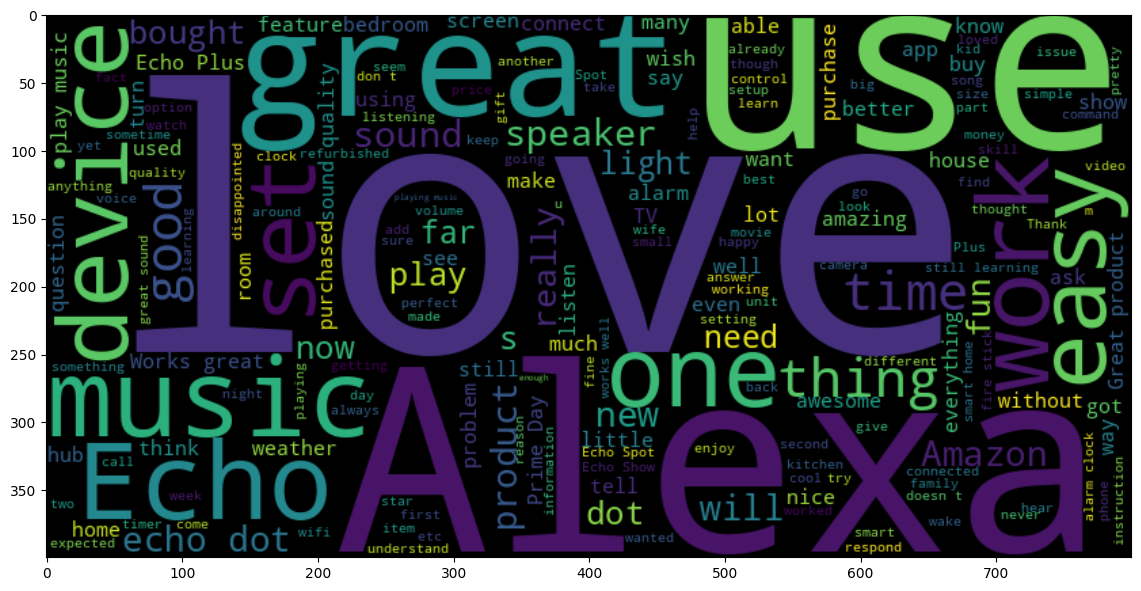

In [116]:
plt.figure(figsize=(14,8))
plt.imshow(WordCloud(width=800, height=400).generate(reviews_text),interpolation='bilinear')

In [117]:
negative_reviews = negative['verified_reviews'].tolist()

In [118]:
len(negative_reviews)

257

In [119]:
negative_text = " ".join(negative_reviews)

In [120]:
negative_text

'It\'s like Siri, in fact, Siri answers more accurately then Alexa.  I don\'t see a real need for it in my household, though it was a good bargain on prime day deals. Sound is terrible if u want good music too get a bose Not much features. Stopped working after 2 weeks ,didn\'t follow commands!? Really fun when it was working? Sad joke. Worthless. Really disappointed Alexa has to be plug-in to wall socket all the time.  My fault for not checking this, but made the assumption that a company has technologically advanced as Amazon would sell this product with a rechargeable battery.  If I could return it, I would as my Apple music and boom speaker give me more flexibility the Alexa. It\'s got great sound and bass but it doesn\'t work all of the time. Its still hot or miss when it recognizes things I am not super impressed with Alexa. When my Prime lapsed, she wouldn\'t play anything. She isn\'t smart enough to differentiate among spotify accounts so we can\'t use it for that either. She r

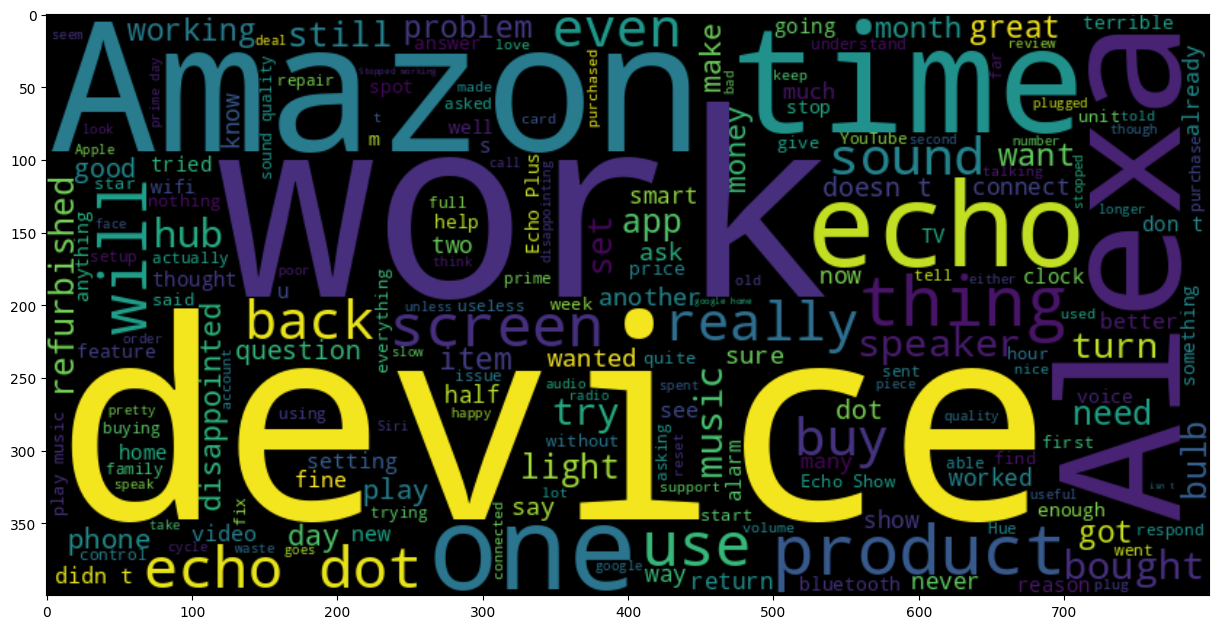

In [121]:
plt.figure(figsize=(15,8))
plt.imshow(WordCloud(width=800, height=400).generate(negative_text),interpolation='bilinear')

In [122]:
df = df.drop(['date','rating','length'], axis = 1)

In [123]:
df

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1
...,...,...,...
3145,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,Black Dot,"Listening to music, searching locations, check...",1
3147,Black Dot,"I do love these things, i have them running my...",1
3148,White Dot,Only complaint I have is that the sound qualit...,1


In [124]:
dummies = pd.get_dummies(df['variation'],drop_first=True).astype(int)

In [125]:
dummies

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [126]:
df.drop(['variation'], axis=1, inplace=True)

In [127]:
df = pd.concat([df,dummies],axis=1)

In [128]:
df

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,"Listening to music, searching locations, check...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,"I do love these things, i have them running my...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,Only complaint I have is that the sound qualit...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [129]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [130]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [131]:
stopwords.words('english')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [132]:
def text_cleaning(text):
    nopunc_text = [char for char in text if char not in string.punctuation]
    nopunc_text_join = ''.join(nopunc_text)
    clean_nopunc_text_join = [word for word in nopunc_text_join.split() if word.lower() not in stopwords.words('english')]
    return clean_nopunc_text_join

In [133]:
clean_df = df['verified_reviews'].apply(text_cleaning)

In [134]:
clean_df

,verified_reviews
0,"[Love, Echo]"
1,[Loved]
2,"[Sometimes, playing, game, answer, question, c..."
3,"[lot, fun, thing, 4, yr, old, learns, dinosaur..."
4,[Music]
...,...
3145,"[Perfect, kids, adults, everyone]"
3146,"[Listening, music, searching, locations, check..."
3147,"[love, things, running, entire, home, TV, ligh..."
3148,"[complaint, sound, quality, isnt, great, mostl..."


In [135]:
print('Original: {}'.format(df['verified_reviews'][3]),'\n\n','Cleaned: {}'.format(clean_df[3]))

Original: I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well. 

 Cleaned: ['lot', 'fun', 'thing', '4', 'yr', 'old', 'learns', 'dinosaurs', 'control', 'lights', 'play', 'games', 'like', 'categories', 'nice', 'sound', 'playing', 'music', 'well']


In [136]:
vectorizer = CountVectorizer(analyzer = text_cleaning)
reviews_countvectorizer = vectorizer.fit_transform(df['verified_reviews'])

In [137]:
print(vectorizer.get_feature_names_out())

['072318' '1' '10' ... '😬' '😳' '🤓']


In [138]:
print(reviews_countvectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [139]:
reviews_countvectorizer.shape

(3150, 5211)

In [140]:
df

,verified_reviews,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,Love my Echo!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Loved it!,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Sometimes while playing a game, you can answer...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,I have had a lot of fun with this thing. My 4 ...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Music,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,"Perfect for kids, adults and everyone in betwe...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,"Listening to music, searching locations, check...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,"I do love these things, i have them running my...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,Only complaint I have is that the sound qualit...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [141]:
df.drop(['verified_reviews'], axis=1, inplace=True)
reviews = pd.DataFrame(reviews_countvectorizer.toarray())

In [142]:
reviews_df = pd.concat([df, reviews], axis=1)

In [143]:
df

,feedback,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3147,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3148,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [144]:
sm = SMOTE(random_state=42)

In [145]:
input_data = df.drop(['feedback'],axis=1)

In [146]:
target = df['feedback']

In [147]:
X , y = sm.fit_resample(input_data,target)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

In [149]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

MultinomialNB()

In [150]:
nb_preds = model_nb.predict(X_test)
nb_preds

array([1, 1, 0, ..., 1, 0, 0])

In [151]:
accuracy = accuracy_score(y_test, nb_preds)
report = classification_report(y_test, nb_preds)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.5639400921658986
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.51      0.54       890
           1       0.55      0.63      0.58       846

    accuracy                           0.56      1736
   macro avg       0.57      0.57      0.56      1736
weighted avg       0.57      0.56      0.56      1736



<Axes: >

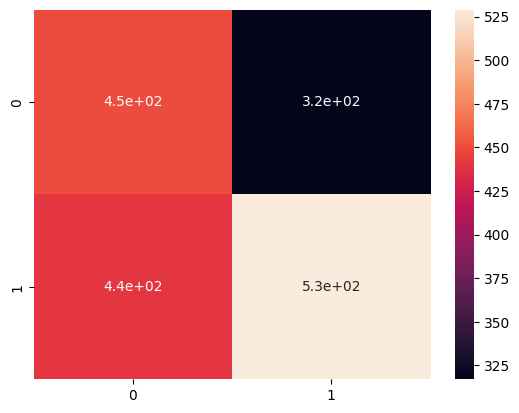

In [152]:
cm = confusion_matrix(nb_preds, y_test)
sns.heatmap(cm , annot=True)

In [153]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

In [154]:
lr_preds = model_lr.predict(X_test)

In [155]:
lr_preds

array([0, 1, 0, ..., 1, 0, 0])

In [156]:
accuracy = accuracy_score(y_test, lr_preds)
report = classification_report(y_test, lr_preds)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.5904377880184332
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.62       890
           1       0.59      0.54      0.56       846

    accuracy                           0.59      1736
   macro avg       0.59      0.59      0.59      1736
weighted avg       0.59      0.59      0.59      1736



<Axes: >

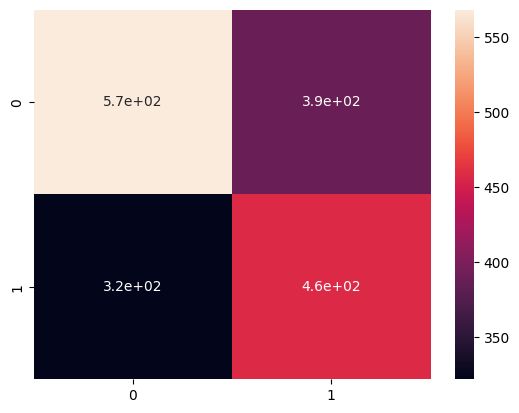

In [157]:
cm = confusion_matrix(lr_preds, y_test)
sns.heatmap(cm, annot = True)